# SOS Control Design

In [ ]:
!apt update && apt -y install xvfb
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1,139 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [25.8 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1,778 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [873 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1,275 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:13 http://archive.ubuntu.com/ubuntu 

In [ ]:
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Math, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression,math,le)
from pydrake.symbolic import Polynomial
from pydrake.systems import controllers

from underactuated import plot_2d_phase_portrait, running_as_notebook

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

if running_as_notebook:
    mpld3.enable_notebook()


In [ ]:
# 1) Initialize Vi(x) and rho(ti) for i=1...N

# Time-varying LQR
def A(x, u, p):
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return np.matrix([[0, 0, 1, 0,       0,       0,       0],
                     [0, 0, 0, 1,       0,       0,       0],
                     [0, 0, 0, 0, -T/m*np.cos(θ+δ), 0, T/m**2*np.sin(θ+δ)],
                     [0, 0, 0, 0, -T/m*np.sin(θ+δ), 0, -T/m**2*np.cos(θ+δ)],
                     [0, 0, 0, 0,       0,       1,       0],
                     [0, 0, 0, 0,       0,       0,       0],
                     [0, 0, 0, 0,       0,       0,       0]])*tf

def B(x, u, p):
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return np.matrix([[     0,            0],
                      [    0,            0],
                      [-np.sin(θ+δ)/m, -T/m*np.cos(θ+δ)],
                      [np.cos(θ+δ)/m, -T/m*np.sin(θ+δ)],
                      [0,            0],
                      [-L/J*np.sin(δ), -L*T/J*np.cos(δ)],
                      [-α,            0       ]])*tf

def interpolation(d_0, d_f, n):
    output = []
    for i in range(n):
        output.append(d_0 + (i) * ((d_f - d_0)/n))

    return output



In [ ]:
# Consts
g = 1.625 # [m/s^2] Gravitational acceleration of the planet
L = 0.5 # [m] Thrust lever arm
J = 100e3; # [kg*m^2] Moment of inertia
Isp = 370 # [s] Specific impulse
g_E = 9.807; # [m/s^2] Earth gravity
alpha = 1 / (Isp * g_E) # [kg/s/N] Fuel consumption rate coefficient
m_wet = 25e3 # [kag] Initial mass
Isp = 370 # [s] Specific impulse
T_min = 20e3 # [N] Minimum thrust
T_max = 80e3 # [N] Maximum thrust
α = 1 / (Isp * g_E) # [kg/s/N] Fuel consumption rate coefficient
m_wet = 25e3 # [kg] Initial mass

# Time steps
N = 20
t = np.linspace(0,80,N)

In [ ]:
def km2m(x):
    return x*1e3 # Conversion from km to m
def kph2mps(v):
    return v/3.6 # Conversion from km/h to m/s
def deg2rad(theta):
    return theta*np.pi/180

x_0 = [km2m(0.5),
       km2m(1.4),
       kph2mps(80),
       kph2mps(-100),
       deg2rad(-30.0),
       deg2rad(0.0),
       m_wet]
T_guess = T_min+0.5*(T_max-T_min) # [N] Initial thrust guess

u_0 = np.array([T_guess,
                0])

x_f = np.zeros(6)
v_0, v_f = x_0[3:4], x_f[3:4]
tf_guess =  82.86256886197
Δm_guess = -α*T_guess*tf_guess
m_dry_guess = x_0[-1]+Δm_guess

x_int = interpolation(x_0, np.hstack((np.zeros((6)), m_dry_guess)), N)
input_int = interpolation(np.array([[T_guess],[0.0]]),np.array([[T_guess],[0.0]]),N)


In [ ]:
# Import trajectory initial guess
x_guess = np.load("xd.npy")
x_guess = x_guess[:,:N]
input_guess = np.load("ud.npy")
input_guess = input_guess[:,:N]

In [ ]:
# 1) Initialize Vi(x) and rho(ti) for i=1...N

# i) solve -S_dot = Q-S(t)B(t)R^-1B^TS(t)+S(t)A(t)+A(t)^TS(t)--------------------
Q = np.identity(len(x_0))
R = np.identity(len(u_0))
S = []


for i in range(N):
    A_matrix = A(x_guess[:,i],input_guess[:,i],[tf_guess])
    B_matrix = B(x_guess[:,i],input_guess[:,i],[tf_guess])

    [K,S_temp] = controllers.LinearQuadraticRegulator(A_matrix,B_matrix,Q,R)
    S.append(S_temp)

In [ ]:
np.dot(K,x_0)

array([-88407.29204771,    664.39812576])

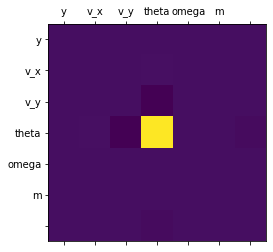

In [ ]:
# initialize figure for animation
fig, ax = plt.subplots()
x_axis_labels=["x","y","v_x","v_y","theta","omega","m"]

ax.set_xticklabels(x_axis_labels)
ax.set_yticklabels(x_axis_labels)


def animate(N):
    for i in range(N):
        ax.matshow(S[i])

ani = FuncAnimation(fig, animate, frames=N+1, interval=1e2)
display(HTML(ani.to_jshtml()))


In [ ]:
# 2) Set rho prev(ti) = 0
rho = np.ones(N)
rho_prev = np.zeros(N)

In [ ]:
# Functions to create new mathematical program

# Create indeterminate array (use only once)
def create_indeterminates():
    dummy_prog = MathematicalProgram()
    x = dummy_prog.NewIndeterminates(1, "x")[0]
    y = dummy_prog.NewIndeterminates(1, "y")[0]
    v_x = dummy_prog.NewIndeterminates(1, "v_x")[0]
    v_y = dummy_prog.NewIndeterminates(1, "v_y")[0]
    theta = dummy_prog.NewIndeterminates(1, "theta")[0]
    omega = dummy_prog.NewIndeterminates(1, "omega")[0]
    m = dummy_prog.NewIndeterminates(1, "m")[0]

    x = np.array([x, y, v_x, v_y, theta, omega, m])
    x_bar = []
    for i in range(x_guess.shape[1]):
        x_bar.append(x-x_guess[:,i])
    x_bar = np.asarray(x_bar)

    return x,x_bar

# ii) Lyapunov candidate---------------------------------------------------------
# Vguess = x_bar^T*S(t)*x_bar
def create_lyapunov_candidate(x):

    V_guess = []
    for i in range(N):
        V_guess.append(np.dot(np.dot(x-x_guess[:,i],S[i]),(x-x_guess[:,i]).T))
        
    return V_guess

# u candidate
def create_u_candidate(x):
    deg_u = 1
    u_bar = []
    for i in range(N):
        u_bar.append(prog.NewFreePolynomial(Variables(x), deg_u).ToExpression())
        u_bar[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})
        u_bar[i] = u_bar[i]-input_guess[:,i]
    return u_bar

# Create new mathematical program (call for each alternation)
def new_math_program(x):

    prog = MathematicalProgram()
    prog.AddIndeterminates(x)

    return prog

# Dynamics (returns x dot)
def x_dot(x,u,p):
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return np.array([[vx, vy, -T/m*np.sin(θ+δ), T/m*np.cos(θ+δ)-g, ω, -L*T/J*np.sin(δ), -alpha*T]])


In [ ]:
# Create indeterminates and lyapunov candidate
x,x_bar = create_indeterminates()
V_guess = create_lyapunov_candidate(x)


In [ ]:
x_guess

array([[ 5.00000000e+02,  6.09098286e+02,  7.25353167e+02,
         8.20963179e+02,  8.69326892e+02,  8.67327329e+02,
         8.19457426e+02,  7.41498796e+02,  6.50122049e+02,
         5.49801285e+02,  4.45986585e+02,  3.43728701e+02,
         2.46663742e+02,  1.59043213e+02,  8.69806827e+01,
         3.92337856e+01,  1.43408554e+01,  2.87820639e+00,
        -2.77258374e-01,  6.87805368e-12],
       [ 1.40000000e+03,  1.28166142e+03,  1.16669817e+03,
         1.07034264e+03,  9.81309895e+02,  8.96901332e+02,
         8.19465141e+02,  7.45974666e+02,  6.67456855e+02,
         5.90273199e+02,  5.15630078e+02,  4.33745130e+02,
         3.45554919e+02,  2.56534439e+02,  1.75076902e+02,
         1.14046541e+02,  7.29417857e+01,  3.90080951e+01,
         1.27184825e+01, -3.41612379e-11],
       [ 2.22222222e+01,  2.66566799e+01,  2.56807258e+01,
         1.69924931e+01,  5.22895088e+00, -6.08725435e+00,
        -1.51995685e+01, -1.97583944e+01, -2.21227146e+01,
        -2.36512378e+01, -2.3

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


KeyError: 'gridOn'

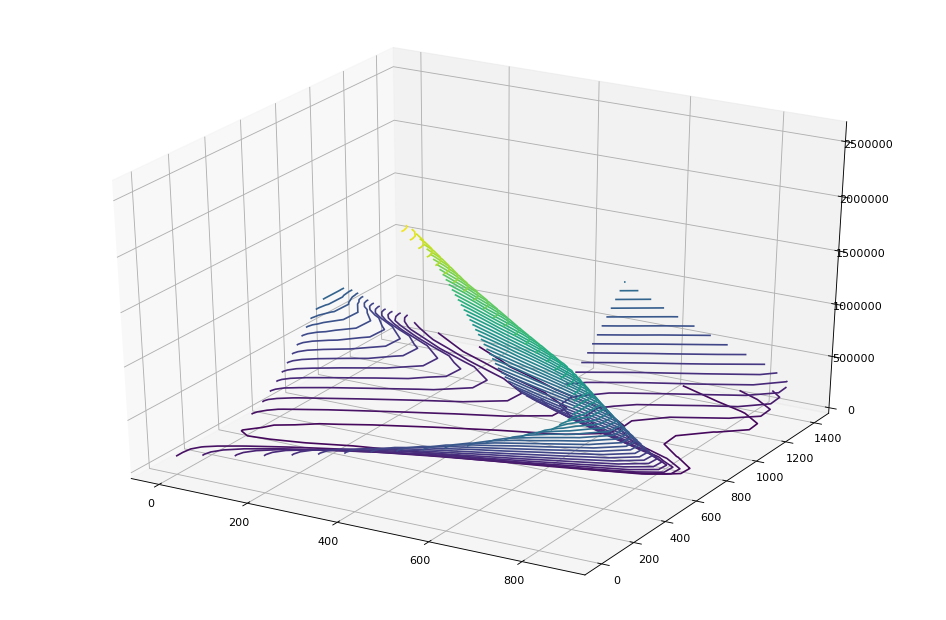

In [ ]:
from mpl_toolkits import mplot3d
from pylab import *

i = 0
def f_poly(x_exec,y_exec,t):
    temp = np.zeros((len(x_exec),len(x_exec)))
    for j in range(len(x_exec)):
        for k in range(len(x_exec)):
            temp[j,k] = (Polynomial(V_guess[t]).Evaluate({x[0]: x_exec[j],x[1]: y_exec[k],x[2]: x_guess[2,t],x[3]: x_guess[3,t],x[4]: x_guess[4,t],x[5]: x_guess[5,t],x[6]: x_guess[6,t]}))
    return temp


fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
#gca().zaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0e}'))

def animate(n):
    for t in range(n):
        X, Y = np.meshgrid(x_guess[0,:],x_guess[1,:])
        Z = f_poly(x_guess[0,:],x_guess[1,:],t)
        ax = plt.axes(projection='3d')
        ax.contour3D(X, Y, Z, 50)

ani = FuncAnimation(fig, animate, frames=N-13, interval=1e3)
display(HTML(ani.to_jshtml()))

In [ ]:
[tf_guess]

[82.86256886197]

## Without Input Limits

In [ ]:
# i) find ui(x), Li(x)-------------------------------------------
# fix Vi(x), rho(ti)
prog = new_math_program(x)
deg_V = 1
deg_L = 1

u_bar = create_u_candidate(x)
L_mult = []

# Create L candidate
for i in range(N):
    L_mult.append(prog.NewFreePolynomial(Variables(x), deg_L).ToExpression())
    L_mult[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})

for i in range(N):
    if i<N-1:
        # Calculate rho dot and V dot
        rho_dot = (rho[i+1]-rho[i])/(t[i+1]-t[i])
        V_dot = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],input_guess[:,i],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])

    prog.AddSosConstraint(V_guess[i])
    prog.AddSosConstraint((-V_dot + rho_dot + L_mult[i]*(V_guess[i]-rho[i])))

# solve SOS program
result = Solve(prog)
u_bar = result.GetSolution(u_bar)
L_mult = result.GetSolution(L_mult)
print('u_bar = ',u_bar)
print('L = ',L_mult)


u_bar =  [[<Expression "-70146.301893892029"> <Expression "0.16880027605732575">]
 [<Expression "-33556.258329435121"> <Expression "0.017490931392977794">]
 [<Expression "-79999.805744759331"> <Expression "0.016761040459419205">]
 [<Expression "-79996.479305970191"> <Expression "-0.093260348736710852">]
 [<Expression "-79999.272603956662"> <Expression "0.0010490072952068982">]
 [<Expression "-79998.851810022315"> <Expression "-0.020957491089488672">]
 [<Expression "-61924.990739075874">
  <Expression "-0.0062471707775206518">]
 [<Expression "-29614.779689814502"> <Expression "0.011859640220863735">]
 [<Expression "-45404.702916223498"> <Expression "0.0026734352794640353">]
 [<Expression "-46897.82509678763"> <Expression "0.0018047708708680867">]
 [<Expression "-25892.280724504002"> <Expression "0.014025301899382669">]
 [<Expression "-31731.510920279565"> <Expression "0.010628175791677642">]
 [<Expression "-39807.908581889817"> <Expression "0.0059295183589450056">]
 [<Expression "-50000

In [ ]:
# export u
u_export = np.zeros((N,2))
for i in range(N):
    u_export[i] = [Polynomial(u_bar[i][0]).Evaluate({}),Polynomial(u_bar[i][1]).Evaluate({})]
#(x_dot(x_guess[:,i],[Polynomial(u_bar[i][0]).Evaluate({}),Polynomial(u_bar[i][1]).Evaluate({})],[tf_guess]))[0][0]
np.save("u_export.npy",u_export)

<ipython-input-11-ff84bc7fe5e7>:55: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([[vx, vy, -T/m*np.sin(θ+δ), T/m*np.cos(θ+δ)-g, ω, -L*T/J*np.sin(δ), -alpha*T]])


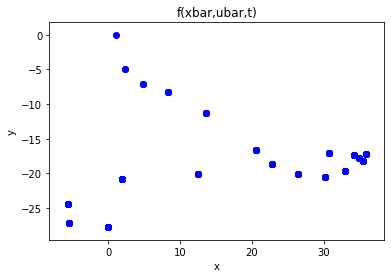

In [ ]:
# initialize figure for animation
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('f(xbar,ubar,t)')

def animate(N):
    for i in range(N):
        ax.scatter((x_dot(x_int[:][i]-x_guess[:,i],[Polynomial(u_bar[i][0]).Evaluate({}),Polynomial(u_bar[i][1]).Evaluate({})],[tf_guess]))[0][0],(x_dot(x_guess[:,i],[Polynomial(u_bar[i][0]).Evaluate({}),Polynomial(u_bar[i][1]).Evaluate({})],[tf_guess]))[0][1],color='blue')

ani = FuncAnimation(fig, animate, frames=N+1, interval=1e2)
display(HTML(ani.to_jshtml()))

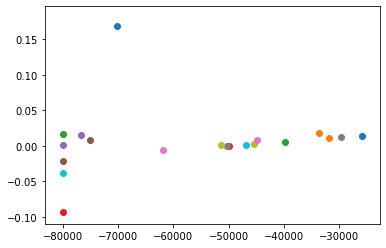

In [ ]:
for i in range(len(u_bar)):
    plt.scatter(Polynomial(u_bar[i][0]).Evaluate({}),Polynomial(u_bar[i][1]).Evaluate({}))

In [ ]:
-V_dot + rho_dot + L_mult[i]*(V_guess[i]-rho[i])

array([<Expression "(-45127300.222356096 - 25.259808229918328 * x(0) - 284.48748206936045 * y(0) - 6144.6379892280856 * v_x(0) - 69327.854647145738 * v_y(0) + 0.51030585760321068 * theta(0) + 1.0088860383715785 * omega(0) + 1881.2528814580276 * m(0) + ((-1 + ((-23728.210478264973 + m(0)) * (80.256838975995436 * (-23728.210478264973 + m(0)) - 2.5141267311482718e-05 * (-5.7349502924353146e-10 + omega(0)) - 432.19325304713595 * (-3.4997782449863735e-11 + v_y(0)) + 0.012808892070768158 * (-6.8780536821577698e-12 + x(0)) + 16.57489281758253 * (3.205968823749572e-11 + v_x(0)) - 0.33396849431755582 * (3.4161237873399399e-11 + y(0)) - 1.5810010328017507e-05 * (5.1904258668855618e-11 + theta(0)))) + ((-5.7349502924353146e-10 + omega(0)) * ( - 2.514128232139352e-05 * (-23728.210478264973 + m(0)) + 24.825671644112102 * (-5.7349502924353146e-10 + omega(0)) - 0.10418147722900373 * (-3.4997782449863735e-11 + v_y(0)) - 0.97228891755011648 * (-6.8780536821577698e-12 + x(0)) - 2.7588265211682299 * (3.2

In [ ]:
# ii) find ui(x), rho(ti) to max sum(rho(ti))-------------------------------------
# fix Vi(x), Li(x)
prog = new_math_program(x)
rho = prog.NewContinuousVariables(N, 'rho')
u_bar = create_u_candidate(x)

for i in range(N):
    if i<N-1:
        rho_dot = (rho[i+1]-rho[i])/(t[i+1]-t[i])
        V_dot = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],input_guess[:,i],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])

    prog.AddSosConstraint(V_guess[i])
    prog.AddSosConstraint((-V_dot + rho_dot + L_mult[i]*(V_guess[i]-rho[i]))[0])

# insert here the objective function (maximize rho)
prog.AddLinearCost(-sum(rho))

# solve SOS program
result = Solve(prog)
u_bar = result.GetSolution(u_bar)
rho = result.GetSolution(rho)

print(u_bar)
print(rho)



KernelInterrupted: Execution interrupted by the Jupyter kernel.

## With Input Limits

In [ ]:
# 3) repeat until converged
not_converged = True

deg_V = 1
deg_L = 1
deg_M = 1

#while not_converged:
# i) find Mu(x), Li(x)-------------------------------------------- 
# fix ui(x), Vi(x), rho(ti)

prog = new_math_program(x)
L_mult = []
M1 = []
M2 = []
u_bar = np.zeros((N,2))

for i in range(N):
    L_mult.append(prog.NewFreePolynomial(Variables(x), deg_L).ToExpression())
    L_mult[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})
for i in range(len(u_0)):
    M1.append(prog.NewFreePolynomial(Variables(x), deg_L).ToExpression())
    M1[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})
    M2.append(prog.NewFreePolynomial(Variables(x), deg_L).ToExpression())
    M2[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})
    
V = V_guess

for i in range(N):
    if i<N-1:
        rho_dot = (rho[i+1]-rho[i])/(t[i+1]-t[i])
        V_dot = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],input_guess[:,i],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_min = np.dot(Polynomial(V_guess[i]).Jacobian(x),f(x_guess[:,i],[T_min,deg2rad(-10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_max = np.dot(Polynomial(V_guess[i]).Jacobian(x),f(x_guess[:,i],[T_max,deg2rad(10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])


    prog.AddSosConstraint(V[i])
    prog.AddSosConstraint(-V_dot + rho_dot + L_mult[i]*(V[i]-rho[i]))
    #prog.AddConstraint(V_dot_min,rho_dot,np.inf)
    #prog.AddLinearConstraint(le(V_dot_max,rho_dot))
    #prog.AddLinearConstraint(le(V_dot,rho_dot))
    prog.AddSosConstraint(M1[0]*(u_bar[i][0]-T_max)+M2[0]*(T_min-u_bar[i][0]))
    prog.AddSosConstraint(M1[1]*(u_bar[i][1]-deg2rad(10))+M2[1]*(deg2rad(-10)-u_bar[i][1]))



# solve SOS program
result = Solve(prog)
M1 = result.GetSolution(M1)
M2 = result.GetSolution(M2)

L_mult = result.GetSolution(L_mult)
print(M1)
print(M2)

print(L_mult)



In [ ]:
# ii) find ui(x), rho(ti)-------------------------------------------
# fix Vi(x), Mu(x)
prog = new_math_program(x)
deg_V = 1
deg_L = 1
deg_M = 1

u_bar = create_u_candidate(x)
#rho = prog.NewContinuousVariables(N, 'rho')
L_mult = []

for i in range(N):
    L_mult.append(prog.NewFreePolynomial(Variables(x), deg_L).ToExpression())
    L_mult[i].Substitute({x[0]: x_bar[i,0],x[1]: x_bar[i,1],x[2]: x_bar[i,2],x[3]: x_bar[i,3],x[4]: x_bar[i,4],x[5]: x_bar[i,5],x[6]: x_bar[i,6]})



for i in range(N):
    if i<N-1:
        rho_dot = (rho[i+1]-rho[i])/(t[i+1]-t[i])
        V_dot = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],input_guess[:,i],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_min = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],[T_min,deg2rad(-10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_max = np.dot(Polynomial(V_guess[i]).Jacobian(x),x_dot(x_guess[:,i],[T_max,deg2rad(10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])


    prog.AddSosConstraint(V_guess[i])
    prog.AddSosConstraint((-V_dot + rho_dot + L_mult[i]*(V_guess[i]-rho[i])))
    #prog.AddLinearConstraint(V_dot_min,rho_dot,np.inf)
    #prog.AddLinearConstraint(le(V_dot_max,rho_dot))
    #prog.AddLinearConstraint(le(V_dot,rho_dot))



# insert here the objective function (maximize rho)
prog.AddLinearCost(-sum(rho))

# solve SOS program
result = Solve(prog)
u_bar = result.GetSolution(u_bar)
L_mult = result.GetSolution(L_mult)
print(u_bar)
print(L_mult)




In [ ]:
# iii) find Vi(x), rho(ti), Mu(x)-------------------------------------
# fix ui(x), Li(x)
prog,x = new_math_program()
V = []
#rho = prog.NewContinuousVariables(N, 'rho')
#M = prog.NewFreePolynomial(Variables(x), deg_M).ToExpression()
V.append(prog.NewFreePolynomial(Variables(x), deg_V).ToExpression())
for i in range(N):
    if i<N-1:
        rho_dot = (rho[i+1]-rho[i])/(t[i+1]-t[i])
        V_dot = np.dot(Polynomial(V_guess[i]).Jacobian(x),f(x_guess[:,i],input_guess[:,i],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_min = np.dot(Polynomial(V_guess[i]).Jacobian(x),f(x_guess[:,i],[T_min,deg2rad(-10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])
        #V_dot_max = np.dot(Polynomial(V_guess[i]).Jacobian(x),f(x_guess[:,i],[T_max,deg2rad(10)],[tf_guess]).T)[0].ToExpression() + (V_guess[i+1]-V_guess[i])/(t[i+1]-t[i])


    prog.AddSosConstraint(V[i])
    prog.AddSosConstraint(-V_dot + rho_dot + L_mult[i]*(V[i]-rho[i]))
    #prog.AddConstraint(V_dot_min,rho_dot,np.inf)
    #prog.AddLinearConstraint(le(V_dot_max,rho_dot))
    #prog.AddLinearConstraint(le(V_dot,rho_dot))
    prog.AddSosConstraint(M1[0]*(u_bar[i][0]-T_max)+M2[0]*(T_min-u_bar[i][0]))
    prog.AddSosConstraint(M1[1]*(u_bar[i][1]-deg2rad(10))+M2[1]*(deg2rad(-10)-u_bar[i][1]))
# insert here the objective function (maximize rho)
#prog.AddLinearCost(-sum(rho))

# solve SOS program
result = Solve(prog)
V = result.GetSolution(V)
rho = result.GetSolution(rho)
M = result.GetSolution(M)
print(V)
print(rho)
print(M)



In [ ]:
rho_sum = 0
for i in range(N):
    rho_sum+=Polynomial(rho[i][0]).Evaluate({})

In [ ]:
    if (rho_sum-sum(rho_prev))/sum(rho_prev) < .01:
        not_converged = False

    rho_prev = rho

<ipython-input-31-46e1b59a12a7>:1: RuntimeWarning: divide by zero encountered in double_scalars
  if (rho_sum-sum(rho_prev))/sum(rho_prev) < .01:


In [ ]:
rho_prev

array([[<Expression "-0.04755551012493265">],
       [<Expression "-2.4045372533598535">]], dtype=object)

In [ ]:
    x_bar = []
    for i in range(len(x_guess)):
        x_bar.append(x-x_guess[i][0])
    x_bar = np.asarray(x_bar)

    V_guess = np.matmul(np.matmul(x_bar,S),x_bar.T)

In [ ]:
def rocket_landing():
    prog = MathematicalProgram()
    g = 1.625 # [m/s^2] Gravitational acceleration of the planet
    L = 0.5 # [m] Thrust lever arm
    J = 100e3; # [kg*m^2] Moment of inertia
    Isp = 370 # [s] Specific impulse
    g_E = 9.807; # [m/s^2] Earth gravity
    alpha = 1 / (Isp * g_E) # [kg/s/N] Fuel consumption rate coefficient

    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s_theta = prog.NewIndeterminates(1, "s_theta")[0]
    c_theta = prog.NewIndeterminates(1, "c_theta")[0]
    s_delta = prog.NewIndeterminates(1, "s_delta")[0]
    c_delta = prog.NewIndeterminates(1, "c_delta")[0]
    x_dot = prog.NewIndeterminates(1, "x_dot")[0]
    y_dot = prog.NewIndeterminates(1, "y_dot")[0]
    theta_dot = prog.NewIndeterminates(1, "theta_dot")[0]
    m = prog.NewIndeterminates(1, "m")[0]

    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s_theta, c_theta, s_delta, c_delta, x_dot, y_dot, theta_dot, m])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c_theta*theta_dot,
        -s_theta*theta_dot,
        c_delta*delta_dot,
        -s_delta*delta_dot,
        -T/m*(s_theta*c_delta + c_theta*s_delta),
        T/m*(c_theta*c_delta - s_theta*s_delta)-g,
        -L*T/J*s_delta,
        -alpha*T_dot,
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0, 1, 0, 0, 0, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also zero
    # at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multipling by s^2).
    constraint2 = prog.AddSosConstraint(-Vdot - L * (s_theta_delta**2 + c_theta_delta**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s_theta_delta**2)
    constraint3 = prog.AddSosConstraint(-Vdot - L * (s_delta**2 + c_delta**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s_delta**2)
 
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.                  

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({
            s_theta: 0,
            c_theta: 1,
            s_delta: 0,
            c_delta: 1,
            x_dot: 0,
            y_dot: 0,
            theta_dot: 0,
            m: 0
        }) == 0)
        
# Call the solver.
result = Solve(prog)
assert result.is_success()

In [ ]:
def global_pendulum():
    prog = MathematicalProgram()
    g = 1.625 # [m/s^2] Gravitational acceleration of the planet
    L = 0.5 # [m] Thrust lever arm
    J = 100e3; # [kg*m^2] Moment of inertia
    Isp = 370 # [s] Specific impulse
    g_E = 9.807; # [m/s^2] Earth gravity
    alpha = 1 / (Isp * g_E) # [kg/s/N] Fuel consumption rate coefficient


    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s_theta = prog.NewIndeterminates(1, "s_theta")[0]
    c_theta = prog.NewIndeterminates(1, "c_theta")[0]
    s_delta = prog.NewIndeterminates(1, "s_delta")[0]
    c_delta = prog.NewIndeterminates(1, "c_delta")[0]
    x_dot = prog.NewIndeterminates(1, "x_dot")[0]
    y_dot = prog.NewIndeterminates(1, "y_dot")[0]
    theta_dot = prog.NewIndeterminates(1, "theta_dot")[0]
    m = prog.NewIndeterminates(1, "m")[0]

    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s_theta, c_theta, s_delta, c_delta, x_dot, y_dot, theta_dot, m])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c_theta*theta_dot,
        -s_theta*theta_dot,
        c_delta*delta_dot,
        -s_delta*delta_dot,
        -T/m*(s_theta*c_delta + c_theta*s_delta),
        T/m*(c_theta*c_delta - s_theta*s_delta)-g,
        theta_dot,
        -L*T/J*s_delta,
        -alpha*T_dot,
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also zero
    # at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multipling by s^2).
    constraint2 = prog.AddSosConstraint(-Vdot - L * (s_theta_delta**2 + c_theta_delta**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s_theta_delta**2)
    constraint3 = prog.AddSosConstraint(-Vdot - L * (s_delta**2 + c_delta**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s_delta**2)
 
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.                  

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({
            s_theta_delta: 0,
            c_theta_delta: 1,
            s_delta: 0,
            c_delta: 1,
            x_dot: 0,
            y_dot: 0,
            theta_dot: 0,
            omega_dot: 0,
            m: 1,
            delta_dot: 0,
            T_dot: 0
        }) == 0)


    # Call the solver.
    result = Solve(prog)
    assert result.is_success()

    # Note that I've added mgl to the potential energy (relative to the textbook),
    # so that it would be non-negative... like the Lyapunov function.
    mgl = p.mass() * p.gravity() * p.length()
    print("Mechanical Energy = ")
    print(.5 * p.mass() * p.length()**2 * thetadot**2 + mgl * (1 - c))

    print("V =")
    Vsol = Polynomial(result.GetSolution(V))
    print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

    # Plot the results as contour plots.
    nq = 151
    nqd = 151
    q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
    qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * p.mass() * p.length()**2 * QD**2 + mgl * (1 - np.cos(Q))
    Vplot = Q.copy()
    env = {s: 0., c: 1., thetadot: 0}
    for i in range(nq):
        for j in range(nqd):
            env[s] = np.sin(Q[i, j])
            env[c] = np.cos(Q[i, j])
            env[thetadot] = QD[i, j]
            Vplot[i, j] = Vsol.Evaluate(env)

    # plt.rc("text", usetex=True)
    fig, ax = plt.subplots()
    ax.contour(Q, QD, Vplot)
    ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
    ax.set_xlabel("theta")
    ax.set_ylabell("thetadot")
    ax.set_title("V (solid) and Mechanical Energy (dashed)")

global_pendulum()

NameError: name 'PendulumParams' is not defined

In [ ]:
# ii) Lyapunov candidate---------------------------------------------------------
# Initialize Vi(x) and rho(ti) for i=1...N
deg_V = 2
deg_L = 2
deg_M = 2

V_guess = []

prog = MathematicalProgram()
# Lyapunov function
V_coeffs = np.zeros(N)
V = prog.NewSosPolynomial(Variables(x), deg_V)[0].ToExpression()
print("Candidate:")
display(V)

prog.AddLinearConstraint(V.Substitute({x[0]: x_0[0],x[1]: x_0[1],x[2]: x_0[2],x[3]: x_0[3],x[4]: x_0[4],x[5]: x_0[5]}) == 1)
Vdot = V.Jacobian(x).dot(f)
display(Vdot)

prog.AddSosConstraint(-Vdot)

result = Solve(prog)

print("Solution:")
display(result.GetSolution(V))
V_guess.append(result.GetSolution(V))

# iii) Goal set Bf = {x_bar | V_guess(x_bar,t)<=rho(t_f)}-------------------------

In [ ]:
# 1) Initialize Vi(x) and rho(ti) for i=1...N

# i) solve -S_dot = Q-S(t)B(t)R^-1B^TS(t)+S(t)A(t)+A(t)^TS(t)--------------------
prog = MathematicalProgram()

# Declare the "indeterminates", x.  These are the variables which define the
# polynomials, but are NOT decision variables in the optimization.  We will
# add constraints below that must hold FOR ALL x.
s_theta = prog.NewIndeterminates(1, "s_theta")[0]
c_theta = prog.NewIndeterminates(1, "c_theta")[0]
x_dot = prog.NewIndeterminates(1, "x_dot")[0]
y_dot = prog.NewIndeterminates(1, "y_dot")[0]
theta_dot = prog.NewIndeterminates(1, "theta_dot")[0]
m = prog.NewIndeterminates(1, "m")[0]

x = np.array([s_theta, c_theta, x_dot, y_dot, theta_dot, m])

# Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
p = PendulumParams()
f = [
    c_theta*theta_dot,
    -s_theta*theta_dot,
    0,
    -g,
    0,
    0
]

# Initial control
T_guess = T_min+0.5*(T_max-T_min) # [N] Initial thrust guess
u_0 = np.array([T_guess,
                T_guess*0,
                T_guess*1])

# Control guess
u = u_0

# Terminal state (without mass)
x_f = np.zeros(8);



In [ ]:
def sos_optimize():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = [-x[0] - 2 * x[1]**2, -x[1] - x[0] * x[1] - 2 * x[1]**3]

    V = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
    print("Candidate:")
    display(V)
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]: 0}) == 0)
    prog.AddLinearConstraint(V.Substitute({x[0]: 1, x[1]: 0}) == 1)
    Vdot = V.Jacobian(x).dot(f)

    prog.AddSosConstraint(-Vdot)

    result = Solve(prog)
    assert result.is_success()

    print("Solution:")
    display(result.GetSolution(V))


sos_optimize()

Candidate:


<Expression "(Symmetric(2,2) + 2 * (x(0) * x(1) * Symmetric(1,0)) + 2 * (x(0) * Symmetric(2,1)) + (pow(x(0), 2) * Symmetric(1,1)) + 2 * (x(1) * Symmetric(2,0)) + (pow(x(1), 2) * Symmetric(0,0)))">

Solution:


<Expression "(1.8065301477010178e-10 + 1.8013219170022866e-13 * x(0) + 1.0000000001297029 * pow(x(0), 2) + 1.9999991174089451 * pow(x(1), 2))">

## Problem Description
In this notebook we will study the time-reversed Van der Pol oscillator.
The equations of motion for this system are polynomial, and read as follows:

$$\begin{aligned}\dot x_1 &= - x_2, \\ \dot x_2 &= x_1 + (x_1^2 - 1) x_2.\end{aligned}$$

We compactly represent the latter as $\dot{\mathbf{x}} = f(\mathbf{x})$, with $\mathbf{x} = [x_1, x_2]^T$.

In [ ]:
# function that implements the time-reversed Van der Pol dynamics
f = lambda x: [- x[1], x[0] + (x[0]**2 - 1) * x[1]]

Here is the phase portrait of the time-reversed Van der Pol oscillator.

As you can see, the origin of this system is locally asymptotically stable whereas, outside the Region Of Attraction (ROA) of the origin, the trajectories escape to infinity.
The boundary of the ROA is an *unstable periodic orbit*:
if the system state at time $t=0$ is exactly on this curve, the oscillator will orbit around the origin forever.
However, any disturbance will make the system either converge to the origin or escape to infinity.
Notice that the shape of this ROA is nontrivial (it is not even a convex set) and no analytic description of it is available.

**Note:**
Reversing the sign of $f$, we obtain the [classical Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator); for which the above periodic orbit is a (globally) asymptotically stable [limit cycle](http://underactuated.mit.edu/simple_legs.html#section1) and the origin is an unstable equilibrium.
Here we reverse time (i.e. change the sign of $f$) to make the origin a stable equilibrium.

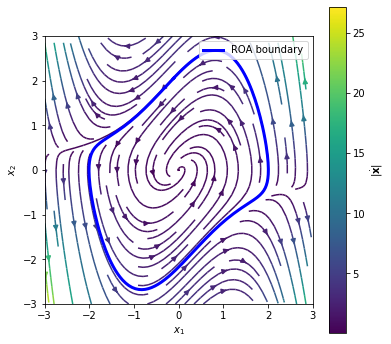

In [ ]:
# compute and plot the unstable periodic orbit
limit_cycle = VanDerPolOscillator.CalcLimitCycle()
plt.plot(limit_cycle[0], limit_cycle[1], color='b', linewidth=3, label='ROA boundary')
plt.legend(loc=1)

# plot the phase portrait
xlim = (-3, 3)
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)

In this notebook we will use Sums-Of-Squares (SOS) optimization to find an inner approximation of the ROA of the equilibrium point in the origin.
We will write three different SOS optimizations, and we will analyze their pros and cons.

## Lyapunov Function via Linearization
The approach we will follow to estimate the ROA of the oscillator is the following:

- We linearize the dynamics $\dot{\mathbf{x}} = f(\mathbf{x})$ around the origin, to get $\dot{\mathbf{x}} = A \mathbf{x}$.

- We solve the Lyapunov equation $$A^T P + P A = - Q$$ to get the matrix $P$, and the Lyapunov function $V(\mathbf{x}) = \mathbf{x}^T P \mathbf{x}$ for the linearized system.

- Lyapunov theory tells us that if $A$ is strictly stable (all its eigenvalues have strictly negative real part) then the origin is a locally asymptotically stable equilibrium point for the nonlinear system $\dot{\mathbf{x}} = f(\mathbf{x})$.
Moreover, a conservative approximation of the ROA can be obtained using the Lyapunov function $V(\mathbf{x})$ derived in the linear analysis.

- We consider the level sets $$L(\rho) = \{ \mathbf{x} : V(\mathbf{x}) \leq \rho \},$$ and we look for the maximum value of $\rho$ such that $$\dot{V}(\mathbf{x}) = \frac{\partial V}{\partial \mathbf{x}} f(\mathbf{x}) = 2 \mathbf{x}^T P f(\mathbf{x}) < 0, \quad \forall \mathbf{x} \in L(\rho)\backslash \{0\}.$$
In words, we try to find the largest level set $L(\rho)$ entirely contained the region of space where $\dot{V}(\mathbf{x})$ is negative.
Lyapunov theory tells us that any trajectory that starts inside such a set will eventually converge to the origin.

We start by deriving $V(\mathbf{x})$.

In [ ]:
# linear approximation A x of f(x)
# for x sufficiently close to the origin
# (if you don't see this immediately, do the math!)
A = np.array([[0, -1], [1, -1]])

# rhs of the Lyapunov equation (standard choice)
Q = np.eye(2)

# positive definite matrix of the Lyapunov function
P = RealContinuousLyapunovEquation(A, Q)

## Manual Check
The advantage of working in 2D is that we can plot things!
Before starting with complicated optimizations, let us plot $V(\mathbf{x})$ and $\dot{V}(\mathbf{x})$ to get a sense of what we are actually looking for in this analysis.

In [ ]:
# function that given rho plots the boundary
# of the the set L(rho) defined above
def plot_V(rho):
    
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(sum(x[i]*x[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(P))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_V([X1, X2]), levels=[rho], colors='r', linewidths=3, zorder=3)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color='r', linewidth=3, label=r'$\{ \mathbf{x} : V(\mathbf{x}) = \rho \}$')
    plt.legend()
    
    return cs
    
# function that plots the levels sets of Vdot(x)
def plot_Vdot():
    
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates Vdot(x) at a given x
    eval_Vdot = lambda x: 2*sum(sum(x[i]*f(x)[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(P))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_Vdot([X1, X2]), colors='b', levels=np.linspace(-10, 40, 11))
    plt.gca().clabel(cs, inline=1, fontsize=10)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color='b', label=r'$\dot{V}(\mathbf{x})$')
    plt.legend()
    
    return cs

By playing with the code below, we see that the largest $\rho$ we can find is $\approx 2.3$.

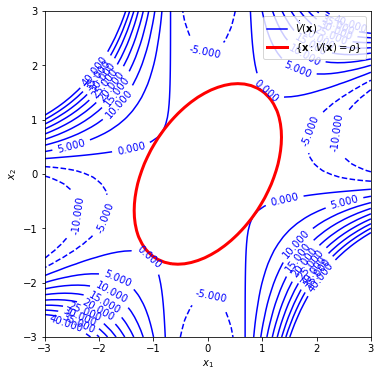

In [ ]:
# tune rho by hand to make it as big as possible
# while staying in the region where Vdot(x) is negative
rho_max = 2.3

# plot Vdot(x) and V(x) = rho
Vdot_cs = plot_Vdot()
V_cs = plot_V(rho_max)

Superimposing the level set to the phase portrait, we see that this is a pretty good approximation of the ROA.

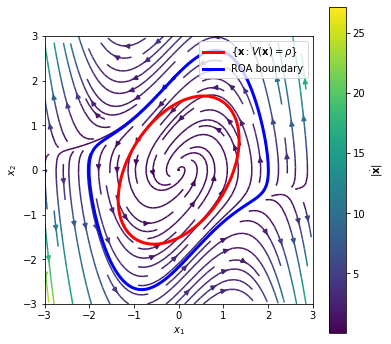

In [ ]:
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)
plot_V(rho_max)
plt.plot(limit_cycle[0], limit_cycle[1], color='b', linewidth=3, label='ROA boundary')
plt.legend(loc=1)

Of course, when $\text{dim}(\mathbf{x}) > 2$, a "manual" maximization of $\rho$ has no hope to work.
That's where SOS programming really makes the difference!
The goal of this notebook is to experiment these tools on a case where things can actually be visualized, so that we get a better sense of the power of this technique.

## Method 1: Line-Search on $\rho$
The first method we use to estimate the ROA is the one from the textbook example "[Region of attraction for the one-dimensional cubic system](http://underactuated.mit.edu/lyapunov.html#roa_cubic_system)".
We look for the largest $\rho$ for which there exists a SOS polynomial $\lambda(\mathbf{x})$ such that $$- \dot{V}(\mathbf{x}) - \lambda(\mathbf{x}) (\rho - V(\mathbf{x})) - \epsilon \mathbf{x}^T \mathbf{x} \ \text{is SOS},$$
with $\epsilon$ very small.
This problem cannot be written as a single SOS program, since both the polynomial $\lambda$ and scalar $\rho$ are decision variables, and here they multiply.
Hence we naively solve a sequence of SOS programs with increasing value of $\rho$.

The intuition behind this formulation is the following.
Think of the condition "is SOS" as "$\geq 0$" (actually, the first is sufficient for the second).
Then what we are asking is $- \dot{V}(\mathbf{x}) \geq \lambda(\mathbf{x}) (\rho - V(\mathbf{x})) + \epsilon \mathbf{x}^T \mathbf{x}$.
Inside the level set $L(\rho)$, we have $\rho - V(\mathbf{x}) \geq 0$ and, since $\lambda(\mathbf{x})$ is SOS, $\lambda(\mathbf{x}) (\rho - V(\mathbf{x})) \geq 0$.
Thus the condition above is just sayng that, for all $\mathbf{x}$ in $L(\rho)$, we must have $- \dot{V}(\mathbf{x})\geq \epsilon \mathbf{x}^T \mathbf{x}$, i.e., $\dot{V}(\mathbf{x})$ negative definite.

In [ ]:
# function that verifies the condition described above
# for the level set L(rho) for a given rho
def is_verified(rho):
    
    # initialize optimization problem
    # (with Drake there is no need to specify that
    # this is going to be a SOS program!)
    prog = MathematicalProgram()
    
    # SOS indeterminates
    x = prog.NewIndeterminates(2, 'x')
    
    # Lyapunov function
    V = x.dot(P).dot(x)
    V_dot = 2*x.dot(P).dot(f(x))
    
    # degree of the polynomial lambda(x)
    # no need to change it, but if you really want to,
    # keep l_deg even (why?) and do not set l_deg greater than 10
    # (otherwise optimizations will take forever)
    l_deg = 4
    assert l_deg % 2 == 0

    # SOS Lagrange multipliers
    l = prog.NewSosPolynomial(Variables(x), l_deg)[0].ToExpression()
    
    # main condition above
    eps = 1e-3 # do not change
    prog.AddSosConstraint(- V_dot - l * (rho - V) - eps*x.dot(x))
    
    # solve SOS program
    # no objective function in this formulation
    result = Solve(prog)
    
    # return True if feasible, False if infeasible
    return result.is_success()

Now that we have the building block of our algorithm, it's your time to write the line search to find the maximum $\rho$ for which the condition described above holds.

Implement the line search in next cell.
Start with `rho = 0`, check if the level set $L(\rho)$ is verified (i.e. the function `is_verified(rho)` returns `True`); if yes, increase `rho` by `rho_step = .01`, if no, assign to the variable `rho_method_1` the maximum verified `rho` you've found with this procedure.

In [ ]:
# line-search parameters
rho = 0 # do not modify
rho_step = .01 # do not modify

# implement your line-search here
while is_verified(rho):
    rho_prev = rho
    rho += rho_step

# set the maximum value of rho you've found with line search
rho_method_1 = rho_prev # modify here
    
# print maximum rho
print(f'Method 1 verified rho = {rho_method_1}.')

Method 1 verified rho = 2.299999999999995.


Did this method do a good job in approximating (from below) the maximum $\rho$ we have found by hand?

Yes, the rho found by hand is 2.3 and the method 1 verified rho is about 2.3.

## Method 2: Single-Shot SOS Program
With the previous formulation we had to solve a sequence of SOS programs, now we consider an equivalent formulation of the SOS problem in which we can directly maximize $\rho$.
In the previous case we wrote a SOS program to check the impication
$$\mathbf{x} \in L(\rho) \Rightarrow \dot{V}(\mathbf{x}) < 0.$$
This, however, can be equivalently stated as
$$\dot{V}(\mathbf{x}) \geq 0 \Rightarrow \mathbf{x} \not\in L(\rho).$$
Expressing $\mathbf{x} \not\in L(\rho)$ as $V(\mathbf{x}) - \rho \geq 0$, it turns out that the latter condition can be verified with a single SOS program.
(Actually, we should say $V(\mathbf{x}) - \rho > 0$, but working with a computer there is no difference.)

The new problem reads as follows.
Find an SOS polynomial $\lambda(\mathbf{x})$ such that
$$V(\mathbf{x}) - \rho - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS}.$$
In fact, this implies $V(\mathbf{x}) - \rho \geq \lambda(\mathbf{x}) \dot{V}(\mathbf{x})$ and, for all $\mathbf{x}$ where $\dot{V}(\mathbf{x}) \geq 0$, we get $V(\mathbf{x}) - \rho \geq 0$.

Notice that now $\lambda$ does not multiply $\rho$, and we can search over both of them at the same time.
Hence we can ask the optimizer to maximize $\rho$.
There is however an issue with the current problem formulation...

### Not quite there yet...

Do you see anything wrong with the problem formulation we put together so far? What do you think the maximum $\rho$ will be?

As stated so far, the problem will always return $\rho = 0$!
To see why, first notice that for $\rho = \lambda = 0$ the SOS condition above would become $V(\mathbf{x})$ is SOS, which holds since $V(\mathbf{x}) = \mathbf{x}^T P \mathbf{x}$.
Now consider a positive $\rho$.
Since $V(0) = \dot{V} (0) = 0$, evaluating the SOS condition in the origin, we would get $-\rho \geq 0$ which can never hold!

Not everything is lost, we have a neat fix for you.
Certainly, if $V(\mathbf{x}) - \rho$ is nonnegative, so is $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho)$.
Hence we consider the SOS condition
$$\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS},$$
with $\lambda(\mathbf{x})$ SOS.
Now the issue in the origin is fixed, since for $\mathbf{x} = 0$, we get "$0$ is SOS", which is always true.
Moreover, where $\mathbf{x}$ is such that $\dot{V}(\mathbf{x}) \geq 0$, the new SOS condition requires $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq 0$ and hence $V(\mathbf{x}) - \rho \geq 0$ as desired.

Now we are good to go!

In the next cell you need to code the SOS program we just described.
We have already set up the problem for you.
You only have to write two lines of code:

- A line where you add the SOS constraint described in the "Not quite there yet..." subsection above.
To do this, use the method `AddSosConstraint` of `MathematicalProgram` (same method we've used in the previous case).

- A line where you set the objective function of the SOS program.
Remember that we'd like to maximize `rho`.
To this end, use the method `AddLinearCost` of `MathematicalProgram`, but notice that writing `prog.AddLinearCost(rho)` the variable `rho` will be *minimized*.
Any idea for a quick workaround?
Hint: it shouldn't take more than one character!

In [ ]:
# initialize optimization problem
prog2 = MathematicalProgram()

# SOS indeterminates
x = prog2.NewIndeterminates(2, 'x')

# Lyapunov function
V = x.dot(P).dot(x)
V_dot = 2*x.dot(P).dot(f(x))

# degree of the polynomial lambda(x)
# no need to change it, but if you really want to,
# keep l_deg even and do not set l_deg greater than 10
l_deg = 4
assert l_deg % 2 == 0

# SOS Lagrange multipliers
l = prog2.NewSosPolynomial(Variables(x), l_deg)[0].ToExpression()

# level set as optimization variable
rho = prog2.NewContinuousVariables(1, 'rho')[0]

# write here the SOS condition described in the "Not quite there yet..." section above
prog2.AddSosConstraint(x.dot(x)*(V-rho)-l*V_dot)

# insert here the objective function (maximize rho)
prog2.AddLinearCost(-rho)

# solve program only if the lines above are filled
if len(prog2.GetAllConstraints()) != 0:

    # solve SOS program
    result = Solve(prog2)

    # get maximum rho
    assert result.is_success()
    rho_method_2 = result.GetSolution(rho)

    # print maximum rho
    print(f'Method 2 verified rho = {rho_method_2}.')

Method 2 verified rho = 2.3044775571670284.


## Method 3: Smarter Single-Shot SOS Program
The SOS program we just wrote was already a satisfying solution, but it turns out we can do even better!
From the textbook chapter "[Lyapunov analysis with convex optimization](http://underactuated.mit.edu/lyapunov.html#section2)", you know that every SOS constraint brings with it a lot of optimization variables and an SDP constraint.
So, whenever we can, removing redundant SOS requirements is always a good thing to do.

We claim that in the previous formulation we don't need $\lambda(\mathbf{x})$ to be SOS. How is this possible?

We start by noticing that, in a neighborhood of the origin, excluded the origin itself, $\dot{V}(\mathbf{x})$ is strictly negative.
(This because $V(\mathbf{x})$ is a Lyapunov function for the linearized system hence, locally, it works also for the nonlinear system.)

In light of the latter observation, instead of asking that $\dot{V}(\mathbf{x})$ is negative for all $\mathbf{x} \neq 0$ in $L(\rho)$, we can equivalently ask that all the points $\mathbf{x} \neq 0$ where $\dot{V}(\mathbf{x}) = 0$ must be outside the level set $L(\rho)$.
This might take a second to parse!

The latter condition can be enforced exactly as the one above:
$$\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS},$$
but this time we do not require $\lambda(\mathbf{x})$ to be SOS.

Here is the reasoning.
First, notice that this condition implies $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq \lambda(\mathbf{x}) \dot{V}(\mathbf{x})$.
Then, observe that for all $\mathbf{x}$ such that $\dot{V}(\mathbf{x}) = 0$, we get $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq 0$.
This implies $V(\mathbf{x}) - \rho \geq 0$, i.e., $\mathbf{x} \not\in L(\rho)$ as desired.
(As before, no need to care about what happens at the boundary of the level set.)

This trick can make a huge difference when you need to verify high-dimensional systems!

To try this new idea:
- In the following cell, copy and paste the optimization problem you just wrote above for "Method 2". Attention: this time give the name `prog3` to the `MathematicalProgram` you write (important for autograding).

- Substitute the definition of the polynomial $\lambda$ from `l = prog.NewSosPolynomial(Variables(x), l_deg)[0].ToExpression()` to `l = prog.NewFreePolynomial(Variables(x), l_deg).ToExpression()`.

- Run the new SOS program.

- Define the variable `rho_method_3` to be the optimal value of `rho` for this new optimization problem.

If you have done thing correctly, `rho_method_3` should "closely match" `rho_method_2`!

In [ ]:
# initialize optimization problem
prog3 = MathematicalProgram()

# SOS indeterminates
x = prog3.NewIndeterminates(2, 'x')

# Lyapunov function
V = x.dot(P).dot(x)
V_dot = 2*x.dot(P).dot(f(x))

# degree of the polynomial lambda(x)
# no need to change it, but if you really want to,
# keep l_deg even and do not set l_deg greater than 10
l_deg = 4
assert l_deg % 2 == 0

# SOS Lagrange multipliers
l = prog3.NewFreePolynomial(Variables(x), l_deg).ToExpression()

# level set as optimization variable
rho = prog3.NewContinuousVariables(1, 'rho')[0]

# write here the SOS condition described in the "Not quite there yet..." section above
prog3.AddSosConstraint(x.dot(x)*(V-rho)-l*V_dot)

# insert here the objective function (maximize rho)
prog3.AddLinearCost(-rho)

# solve program only if the lines above are filled
if len(prog3.GetAllConstraints()) != 0:

    # solve SOS program
    result = Solve(prog3)

    # get maximum rho
    assert result.is_success()
rho_method_3 = result.GetSolution(rho)

# print maximum rho
print(f'Method 3 verified rho = {rho_method_3}.')

Method 3 verified rho = 2.3044775606983223.


## Final Note
More advanced techniques to approximate ROAs are available.
Generally they require some sort of alternation between optimizing over the multiplier $\lambda$ (as we did here) and modifying the shape of the Lyapunov function $V(\mathbf{x})$, e.g., by considering higher-order polynomials (here we stuck to the quadratic one coming from
linear analysis).
The level set $\rho$ is generally kept fixed (e.g. equal to unity) since, when reshaping the Lyapunov function, the optimizer is allowed to scale the range of this function arbitrarily.

Here is an image of SOS in its full glory approximating the ROA of the Van der Pol oscillator.
Impressive, isn't it?!

![figure](https://raw.githubusercontent.com/RussTedrake/underactuated/master/figures/exercises/van_der_pol_roa.png)
(Courtesy of Shen Shen.)

## Autograding

You can check your work by running the following cell:

In [ ]:
from underactuated.exercises.lyapunov.van_der_pol.test_van_der_pol import TestVanDerPol
from underactuated.exercises.grader import Grader
Grader.grade_output([TestVanDerPol], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 15/15.

Score for Test level set for Method 1 is 5/5.

Score for Test level set for Method 2 is 5/5.

Score for Test level set for Method 3 is 5/5.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e83eda3-2c5c-4366-a032-ee7e648d6c0b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>